In [2]:
__author__ = 'Nikola Djuza RA6-2012'

%matplotlib inline
import numpy as np
import collections
import sys
import cv2
import scipy as sc
import matplotlib.pyplot as plt

# pylab.rcParams['figure.figsize'] = 16, 12

from sklearn.cluster import KMeans
from midiutil.MidiFile import MIDIFile

In [3]:
def display_image(image, color = False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def load_and_prepare_image(image_path):
    image = cv2.imread(image_path)
    ret, image_bin = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

    return image_bin

In [4]:
def create_fiveline(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    ys = list()
    minLineLength = 1
    maxLineGap = 10

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 70, minLineLength, maxLineGap)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1,y1), (x2,y2), (0, 255, 0), 2)
            if (abs(y1 - y2 < 4)):
                innerlist = list()
                innerlist.append((y1 + y2) / 2)
                ys.append(innerlist)
    
    cv2.imwrite('images/houghlines.jpg', image)
    display_image(image)

    kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
    kmeans.fit(np.asarray(ys))

    fiveline = list()
    for innerlist in kmeans.cluster_centers_:
        fiveline.append(innerlist[0])

    fiveline.sort()
    print fiveline
    return fiveline

In [5]:
def create_checks(fiveline):
    checks = list()
    dist = abs(fiveline[1] - fiveline[0])
    
    for line in fiveline:
        checks.append(int(line - (dist / 4)))
        checks.append(int(line + (dist / 4)))

    checks.sort()
    checks.reverse()
    return checks

In [6]:
def create_bars_coordinates(img, fiveline, checks):
    barsBegins = list();
    barsEnds = list();
    bars = list()

    height, width = img.shape[:2]

    barsFlag = False
    leftCounter = 0
    rightCounter = 0
    for x in range(width):
        gen = (i for i in range(int(fiveline[0] + 2), int(fiveline[4])) if img[i, x][0] == 0)

        c = 0
        for i in gen:
            c += 1

        if barsFlag is False and c == abs(int(fiveline[0] + 2) - int(fiveline[4])):

            for l in range(x - 5, x - 2):
                for y in checks:
                    if img[y, l][0] == 0:
                        # gray[y, x] = [255, 0, 0]
                        leftCounter += 1

            barsBegins.append(x)
            barsFlag = True

        if barsFlag is True and not (c == abs(int(fiveline[0] + 2) - int(fiveline[4]))):

            for r in range(x + 2, x + 5):
                for y in checks:
                    if img[y, r][0] == 0:
                        # gray[y, x] = [255, 0, 0]
                        rightCounter += 1
            barsEnds.append(x)
            barsFlag = False

            if leftCounter > 0 or rightCounter > 0:
                # barsEnds.
                barsEnds.pop(len(barsEnds) - 1)
                barsBegins.pop(len(barsBegins) - 1)
            leftCounter = 0
            rightCounter = 0

    print
    print barsBegins
    print barsEnds
    print

    return barsBegins, barsEnds

In [7]:
def find_all_notes(noteValues, img, checks, barsBegins, barsEnds):
    iTunes = list()
    for bar in range(len(barsBegins) - 1):
        barLength = abs(barsEnds[bar] - barsBegins[bar + 1]) - 2
        pointsX = list()
        pointsY = list()
        for x in range(barsEnds[bar] + 1, barsBegins[bar + 1] - 1):
            for y in checks:
                if img[y, x][0] == 0:
                    # gray[y, x] = [255, 0, 0]
                    innerlistX = list()
                    innerlistX.append(x)
                    innerlistY = list()
                    innerlistY.append(y)
                    pointsX.append(innerlistX)
                    pointsY.append(innerlistY)

        kmeans2 = KMeans(init='k-means++', n_clusters=4, n_init=10)
        kmeans2.fit(np.asarray(pointsX), np.asarray(pointsY))

        notes = list()
        kmeans2.cluster_centers_.sort(axis=0)
        if abs(kmeans2.cluster_centers_[3, 0] - kmeans2.cluster_centers_[0, 0]) < 2:
            continue

        # print kmeans2.cluster_centers_
        notes.append(kmeans2.cluster_centers_[0, 0])

        for cc in range(1, kmeans2.cluster_centers_.shape[0]):
            if abs(kmeans2.cluster_centers_[cc, 0] - notes[len(notes) - 1]) > (
                        abs(barsEnds[bar] - barsBegins[bar + 1]) - 2) / 6:
                notes.append(kmeans2.cluster_centers_[cc, 0])
            else:
                notes[len(notes) - 1] = (notes[len(notes) - 1] + kmeans2.cluster_centers_[cc, 0]) / 2

        print notes

        notePointsList = list()
        for note in notes:
            notePoints = 0
            for x in range(int(note - barLength / 14), int(note + barLength / 14)):
                for y in checks:
                    if img[y, x][0] == 0:
                        # gray[y, x] = [255, 0, 0]
                        notePoints += 1

            print notePoints
            notePointsList.append(notePoints)

        for note in notes:
            noteLength = 0
            if len(notes) == 1:
                noteLength = 4
            elif len(notes) == 2:
                noteLength = 2;
            elif len(notes) == 3:
                if notes.index(note) == notePointsList.index(min(notePointsList)):
                    noteLength = 2
                else:
                    noteLength = 1
            elif len(notes) == 4:
                noteLength = 1

            noteHeight = 0
            for l in range(int(note - 20), int(note + 20)):
                ntCounter = 0
                for y in checks:
                    if img[y, l][0] == 0:
                        ntCounter += 1
                if ntCounter == 2:
                    for y in checks:
                        if img[y, l][0] == 0:
                            noteHeight = noteValues[checks.index(y)]
                            break;

                    break

            iTunes.append((noteLength, noteHeight))

        print
    print iTunes
    return iTunes

In [8]:
def export_tunes_to_MIDI_file(iTunes, outputPath):
    MyMIDI = MIDIFile(1)

    track = 0
    time = 0

    MyMIDI.addTrackName(track, time, "Sample Track")
    MyMIDI.addTempo(track, time, 240)

    track = 0
    channel = 0
    pitch = 60
    time = 0
    duration = 1
    volume = 100

    time = 0
    for noteLength, noteHeight in iTunes:
        MyMIDI.addNote(track, channel, noteHeight, time, noteLength, volume)
        time += duration * noteLength

    binfile = open(outputPath, 'wb')
    MyMIDI.writeFile(binfile)
    binfile.close()

In [15]:
def create_MIDI_file_from_img(img_path, note_values):
    full_img_path = 'images/' + img_path + '.png'
    img = load_and_prepare_image(full_img_path)

    height, width = img.shape[:2]

    fiveline = create_fiveline(img)

    checks = create_checks(fiveline)

    barsBegins, barsEnds = create_bars_coordinates(img, fiveline, checks)

    iTunes = find_all_notes(note_values, img, checks, barsBegins, barsEnds)

    export_tunes_to_MIDI_file(iTunes, 'images/' + img_path + ".mid")

[41.461538461538439, 61.243902439024367, 80.977272727272734, 101.24390243902437, 121.27027027027025]

[48, 278, 623, 921, 1267, 1496]
[53, 282, 628, 925, 1271, 1501]

[122.35075757575758]
33

[341.765625, 423.40909090909093, 504.69047619047626]
68
66
42

[694.42391304347825, 810.67794970986461]
58
58

[994.82352941176453, 1108.2857142857142, 1189.7266666666665]
51
63
74

[1338.7146464646464]
34

[(4, 60), (1, 59), (1, 60), (2, 59), (2, 55), (2, 55), (2, 52), (1, 57), (1, 52), (4, 52)]
[41.199999999999989, 61.424242424242415, 80.86666666666666, 101.19999999999999, 121.30769230769229]

[48, 278, 623, 921, 1267, 1496]
[53, 282, 628, 925, 1271, 1501]

[122.31666666666666]
32

[340.84931506849313, 424.42207207207207, 505.39534883720938]
73
67
43

[694.42391304347825, 810.64791133844847]
58
74

[989.28571428571411, 1073.1486486486488, 1154.8235294117646, 1224.8235294117646]
63
74
51
51

[1338.7146464646464]
34

[(4, 60), (1, 52), (1, 60), (2, 59), (2, 55), (2, 55), (1, 57), (1, 52), (1, 52),

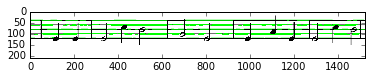

In [32]:
note_values = (52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83)

create_MIDI_file_from_img('test', note_values)
create_MIDI_file_from_img('notes', note_values)
create_MIDI_file_from_img('bibermore_notes', note_values)
create_MIDI_file_from_img('brankamore_notes', note_values)
create_MIDI_file_from_img('brankatest', note_values)
create_MIDI_file_from_img('more_notes', note_values)
create_MIDI_file_from_img('more_notes-1', note_values)
create_MIDI_file_from_img('notes-1', note_values)

In [25]:
!ipython nbconvert --to script note-play.ipynb

[NbConvertApp] Converting notebook note-play.ipynb to script
[NbConvertApp] Writing 7903 bytes to note-play.py
